<a href="https://colab.research.google.com/github/solobala/CVML10/blob/main/CVML10_%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0__3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [4]:
train = np.loadtxt('/content/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('/content/test.csv', delimiter=',', skiprows=1)

In [6]:
train.shape

(42000, 785)

In [5]:
# сохраняем разметку в отдельную переменную - это нулевой столбец
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду ( было 785 столобцов,без таргета 784, это 28**2)
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [7]:
train_img.shape # у нас 42 тыс. изображений 28х28 пикселей

(42000, 28, 28)

## Визуализируем исходные данные

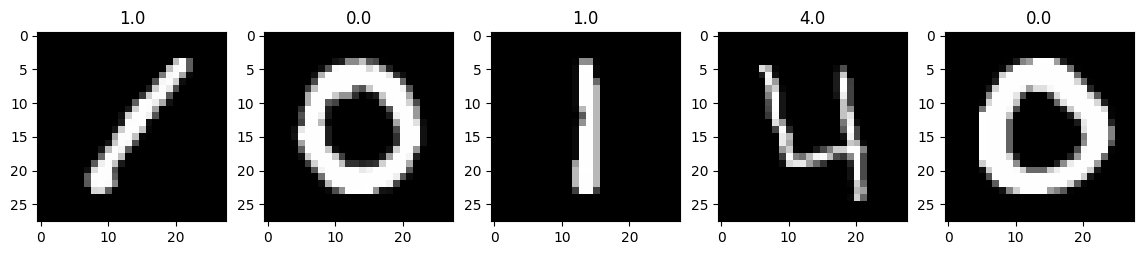

In [8]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):  # первые 5 изображений
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [9]:
# Будет столько же x и y градиентов, сколько пикселей в каждом train_img.
# инициализируем для каждой составляюще  градиента numpy массив нужной размерногсти нулями
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [11]:
# то же самое для теста
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [12]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [13]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

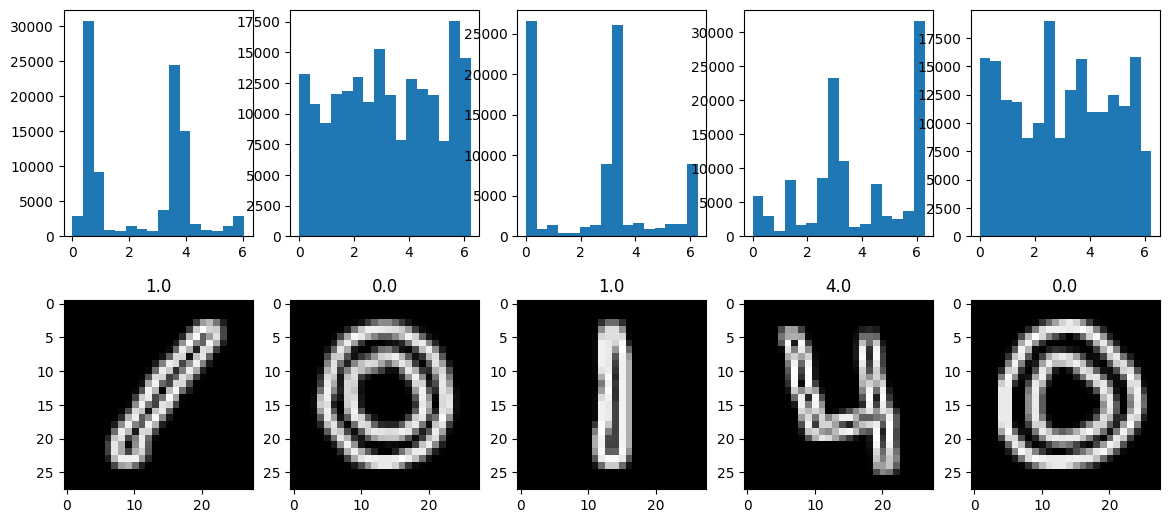

In [14]:
# строим гистограмму для угов пворота для 5 первых
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [15]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [16]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [17]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [18]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [19]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [20]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [21]:
# для каждого из 10 классов усредняем все гистограммы градиентов
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [26]:
# Дальше для каждого изображения из x_val - считаем расстояние между векторами гистограммы и центроидами - правильный класс - при минимальном расстоянии
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [23]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.4270238095238095


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.34      0.12      0.18       816
         1.0       0.59      0.76      0.66       909
         2.0       0.33      0.29      0.31       846
         3.0       0.55      0.49      0.51       937
         4.0       0.33      0.31      0.32       839
         5.0       0.46      0.67      0.55       702
         6.0       0.24      0.45      0.31       785
         7.0       0.73      0.41      0.53       893
         8.0       0.39      0.49      0.44       835
         9.0       0.48      0.27      0.34       838

    accuracy                           0.43      8400
   macro avg       0.44      0.43      0.42      8400
weighted avg       0.45      0.43      0.42      8400



In [25]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[102  24  82  30 106  18 221   7 179  47]
 [  0 692   2   0  44   1 139  17  13   1]
 [ 21   0 245 158  12 203  54  16 119  18]
 [ 14   0 113 456   3 235   7   2  98   9]
 [ 11 248   5   2 260   0 205  43  37  28]
 [  3   0  84  97   5 472   3   4  33   1]
 [ 53  26  66  11 116   4 355  13  76  65]
 [  4 113  38  16  66  41 189 368  15  43]
 [ 81   6  68  44  36  44 107   3 411  35]
 [ 11  73  31  20 149  11 222  30  65 226]]


## Предсказания на тестовыйх данных

In [ ]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

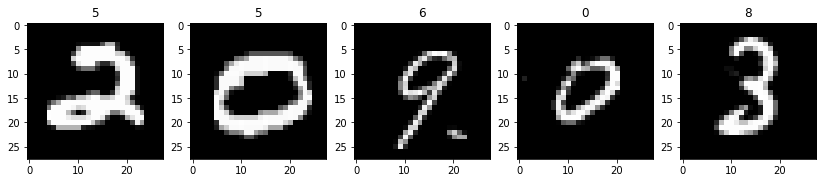

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
!head submit.txt

In [ ]:
# Your submission scored 0.41700